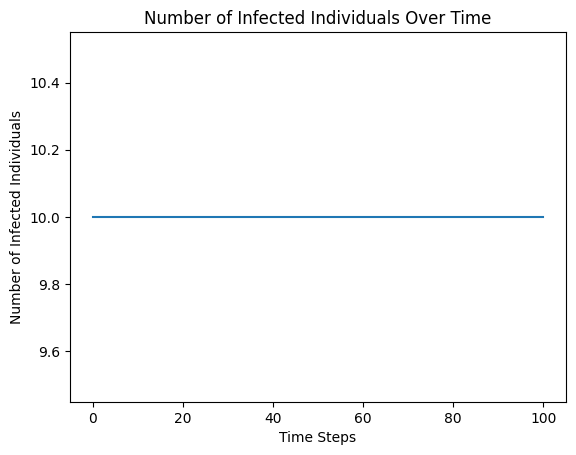

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Parameters
gamma = 0.9        # Discount factor
alpha = 0.1        # Learning rate
num_episodes = 5000  # Number of episodes
max_steps = 100    # Maximum steps per episode

# SIS model parameters
beta = 0.3         # Infection rate
delta = 0.1        # Recovery rate
lambda_arr = 0#0.05  # Arrival rate
lambda_dep = 0#0.02  # Departure rate
intervention_effectiveness = 0.5  # Reduction in infection rate due to intervention

# Define state space and action space
states = [(i, j) for i in range(21) for j in range(21)]  # (n_I, n_S) pairs
actions = ["do_nothing", "intervene"]

# Initialize Q-table
Q = defaultdict(lambda: np.zeros(len(actions)))

# Reward function
def reward(state):
    n_I, n_S = state
    return -n_I  # Negative reward proportional to the number of infected individuals

# Transition function
def transition(state, action):
    n_I, n_S = state
    if action == "do_nothing":
        new_beta = beta
    else:
        new_beta = beta * (1 - intervention_effectiveness)

    # Calculate probabilities of infection and recovery
    p_infection = new_beta * n_I * n_S / (n_I + n_S + 1)
    p_recovery = delta * n_I
    p_arrival = lambda_arr
    p_departure = lambda_dep

    # Update state based on probabilities
    if np.random.rand() < p_infection:
        n_I += 1
        n_S -= 1
    if np.random.rand() < p_recovery:
        n_I -= 1
        n_S += 1
    if np.random.rand() < p_arrival:
        if np.random.rand() < 0.5:  # 50% chance new arrival is susceptible
            n_S += 1
        else:
            n_I += 1
    if np.random.rand() < p_departure:
        if np.random.rand() < 0.5 and n_S > 0:  # 50% chance susceptible departs
            n_S -= 1
        elif n_I > 0:
            n_I -= 1

    # Ensure state variables are non-negative
    n_I = max(0, n_I)
    n_S = max(0, n_S)
    
    return (n_I, n_S)

# Q-learning algorithm
def q_learning():
    for episode in range(num_episodes):
        state = (10, 10)  # Start with some initial number of infected and susceptible
        for step in range(max_steps):
            if np.random.rand() < 0.1:
                action = np.random.choice(actions)  # Exploration
            else:
                action = actions[np.argmin(Q[state])]  # Exploitation
            
            next_state = transition(state, action)
            reward_value = reward(state)
            best_next_action = np.argmin(Q[next_state])
            td_target = reward_value + gamma * Q[next_state][best_next_action]
            td_error = td_target - Q[state][actions.index(action)]
            Q[state][actions.index(action)] += alpha * td_error
            state = next_state

# Train the Q-learning agent
q_learning()

# Test the learned policy
def test_policy():
    state = (10, 10)  # Initial state
    states_visited = [state]
    for step in range(max_steps):
        action = actions[np.argmin(Q[state])]
        state = transition(state, action)
        states_visited.append(state)
    return states_visited

# Run the policy test and visualize the results
states_visited = test_policy()
infected_counts = [state[0] for state in states_visited]

plt.plot(infected_counts)
plt.xlabel('Time Steps')
plt.ylabel('Number of Infected Individuals')
plt.title('Number of Infected Individuals Over Time')
plt.show()


In [11]:
def baseline_policy(state):
    return "do_nothing"  # Simple baseline policy: always do nothing


In [12]:
def evaluate_policy(policy, num_episodes=100, max_steps=100):
    total_rewards = []
    for episode in range(num_episodes):
        state = (10, 10)  # Initial state
        total_reward = 0
        for step in range(max_steps):
            action = policy(state)
            next_state = transition(state, action)
            reward_value = reward(state)
            total_reward += reward_value
            state = next_state
        total_rewards.append(total_reward)
    return total_rewards

# Define the learned policy
def learned_policy(state):
    return actions[np.argmin(Q[state])]

# Evaluate both policies
baseline_rewards = evaluate_policy(baseline_policy)
learned_rewards = evaluate_policy(learned_policy)

# Compare the average reward of both policies
print(f"Average reward (Baseline Policy): {np.mean(baseline_rewards)}")
print(f"Average reward (Learned Policy): {np.mean(learned_rewards)}")


Average reward (Baseline Policy): -1000.0
Average reward (Learned Policy): -1000.0


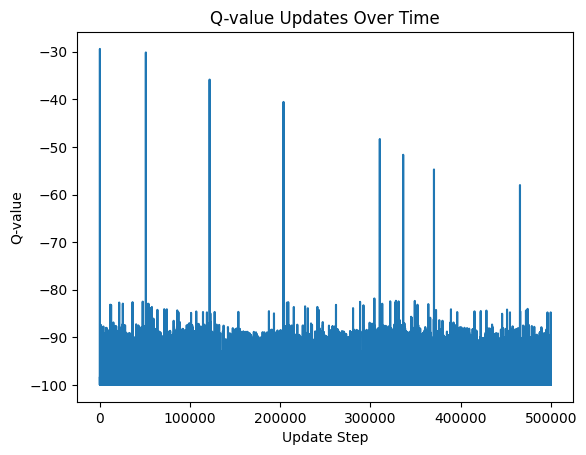

In [13]:
# Track Q-value updates during training
q_value_updates = []

def q_learning_with_tracking():
    global q_value_updates
    for episode in range(num_episodes):
        state = (10, 10)  # Start with some initial number of infected and susceptible
        for step in range(max_steps):
            if np.random.rand() < 0.1:
                action = np.random.choice(actions)  # Exploration
            else:
                action = actions[np.argmin(Q[state])]  # Exploitation
            
            next_state = transition(state, action)
            reward_value = reward(state)
            best_next_action = np.argmin(Q[next_state])
            td_target = reward_value + gamma * Q[next_state][best_next_action]
            td_error = td_target - Q[state][actions.index(action)]
            Q[state][actions.index(action)] += alpha * td_error
            
            # Record Q-value update
            q_value_updates.append(Q[state][actions.index(action)])
            state = next_state

# Train the Q-learning agent with tracking
q_learning_with_tracking()

# Plot Q-value updates to analyze convergence
plt.plot(q_value_updates)
plt.xlabel('Update Step')
plt.ylabel('Q-value')
plt.title('Q-value Updates Over Time')
plt.show()


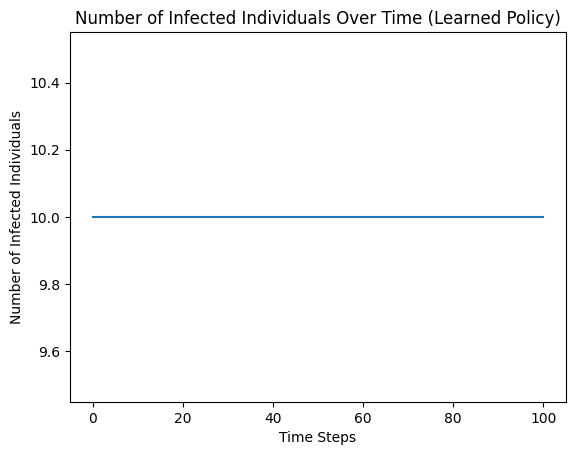

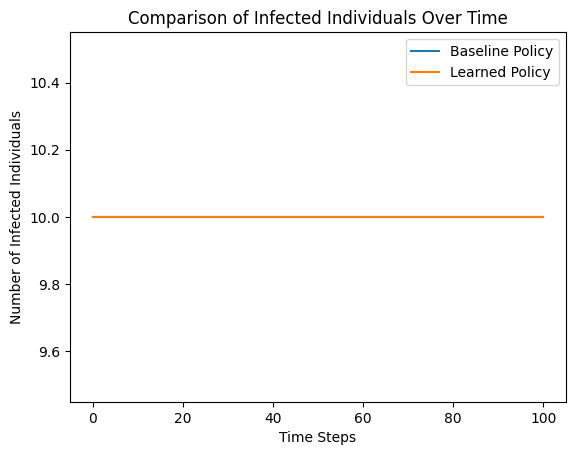

In [14]:
# Run the policy test and visualize the results
states_visited = test_policy()
infected_counts = [state[0] for state in states_visited]

plt.plot(infected_counts)
plt.xlabel('Time Steps')
plt.ylabel('Number of Infected Individuals')
plt.title('Number of Infected Individuals Over Time (Learned Policy)')
plt.show()

# Compare with baseline policy
def test_baseline_policy():
    state = (10, 10)  # Initial state
    states_visited = [state]
    for step in range(max_steps):
        action = baseline_policy(state)
        state = transition(state, action)
        states_visited.append(state)
    return states_visited

baseline_states_visited = test_baseline_policy()
baseline_infected_counts = [state[0] for state in baseline_states_visited]

plt.plot(baseline_infected_counts, label='Baseline Policy')
plt.plot(infected_counts, label='Learned Policy')
plt.xlabel('Time Steps')
plt.ylabel('Number of Infected Individuals')
plt.title('Comparison of Infected Individuals Over Time')
plt.legend()
plt.show()
